Remember:
<br>
- shape of tensor whose gradient needs to be calculated
<br>
- shape of the tensor == shape of its gradient
<br>
- broadcasting affects gradient
<br>
- operations along axes affects gradients, ensure that gradients flow appropriately backward, becuase shapes change so grads might accumulate or might not accumulate
<br>
- variables, only meant for numerical stability, should have grad = 0.0
<br>
- braoadcast in forward pass means a sum in backward pass
<br>
- sum in forward pass means a broadcast in backward pass

In [1]:
from torch import (
    all, allclose, arange, float32, ones_like,
    tensor, zeros_like
    )
from typing import Tuple

from manualForwardPass_6 import *

def compareTheDerivatives(x:str) -> Tuple[bool, str]:
    torch_grad = eval(x).grad; our_grad = eval(x+"_global_grad")
    if all(torch_grad == our_grad).item(): return True, "exact"
    else: return (
        allclose(torch_grad, our_grad),
        "%.16f"%float((torch_grad - our_grad).abs().max().item())
        )

In [2]:
# backward pass init (see chainRule_2.ipynb)
negative_mean_log_likelihood_global_grad = tensor([1.0])
compareTheDerivatives("negative_mean_log_likelihood")

(True, 'exact')

In [3]:
##1. negative_mean_log_likelihood = -mean_log_likelihood
mean_log_likelihood_local_grad = -1
mean_log_likelihood_global_grad = mean_log_likelihood_local_grad * \
                                    negative_mean_log_likelihood_global_grad
compareTheDerivatives("mean_log_likelihood")

(True, 'exact')

In [5]:
##2. mean_log_likelihood = log_probabilities.mean()
log_probabilities_local_grad = ones_like(log_probabilities, dtype=float32) / n
log_probabilities_global_grad = log_probabilities_local_grad * \
                                    mean_log_likelihood_global_grad
compareTheDerivatives("log_probabilities")

(True, 'exact')

In [6]:
##3. log_probabilities = req_normalised_exponents.log()
req_normalised_exponents_local_grad = 1/req_normalised_exponents
req_normalised_exponents_global_grad = req_normalised_exponents_local_grad * \
                                    log_probabilities_global_grad
compareTheDerivatives("req_normalised_exponents")

(True, 'exact')

In [7]:
##4. req_normalised_exponents = normalised_exponents[arange(n), y_train_batch]
normalised_exponents_global_grad = zeros_like(
    normalised_exponents, dtype=float32
    )
normalised_exponents_global_grad[
    arange(n), y_train_batch
    ] = req_normalised_exponents_global_grad
compareTheDerivatives("normalised_exponents")

(True, 'exact')

In [8]:
##5. normalised_exponents = exponentiated / exponentiated_sum_along_rows
exponentiated_sum_along_rows_global_grad = (
     -exponentiated/exponentiated_sum_along_rows**2 * normalised_exponents_global_grad
     ).sum(ALONG_ROWS, keepdim=True)
compareTheDerivatives("exponentiated_sum_along_rows")

(True, 'exact')

In [9]:
##5. normalised_exponents = exponentiated / exponentiated_sum_along_rows
exponentiated_local_grad_1 = 1 / exponentiated_sum_along_rows
exponentiated_global_grad_1 = exponentiated_local_grad_1 * \
                                  normalised_exponents_global_grad
##6. exponentiated_sum_along_rows = exponentiated.sum(ALONG_ROWS, keepdims=True)
exponentiated_global_grad_2 = ones_like(exponentiated, dtype=float32) * \
                                  exponentiated_sum_along_rows_global_grad
exponentiated_global_grad = exponentiated_global_grad_1 + \
                                exponentiated_global_grad_2
compareTheDerivatives("exponentiated")

(True, 'exact')

In [10]:
##7. exponentiated = logits_normalised.exp()
logits_normalised_local = logits_normalised.exp()
logits_normalised_global_grad = logits_normalised_local * \
                                    exponentiated_global_grad
compareTheDerivatives("logits_normalised")

(True, 'exact')

In [11]:
##8. logits_normalised = logits - logits_max_along_rows
logits_max_along_rows_global_grad = -logits_normalised_global_grad.clone().sum(
    ALONG_ROWS, keepdim=True
    )
compareTheDerivatives("logits_max_along_rows")

(True, 'exact')

In [12]:
##8. logits_normalised = logits - logits_max_along_rows
logits_global_grad_1 = logits_normalised_global_grad.clone()
# 9. logits_max_along_rows = logits.max(ALONG_ROWS, keepdims=True).values
logits_global_grad_2 = zeros_like(logits, dtype=float32)
logits_global_grad_2[
    arange(n),
    logits.max(ALONG_ROWS, keepdims=True).indices
    ] = logits_max_along_rows_global_grad
logits_global_grad = logits_global_grad_1 + logits_global_grad_2
compareTheDerivatives("logits")

(True, '0.0000000372529030')

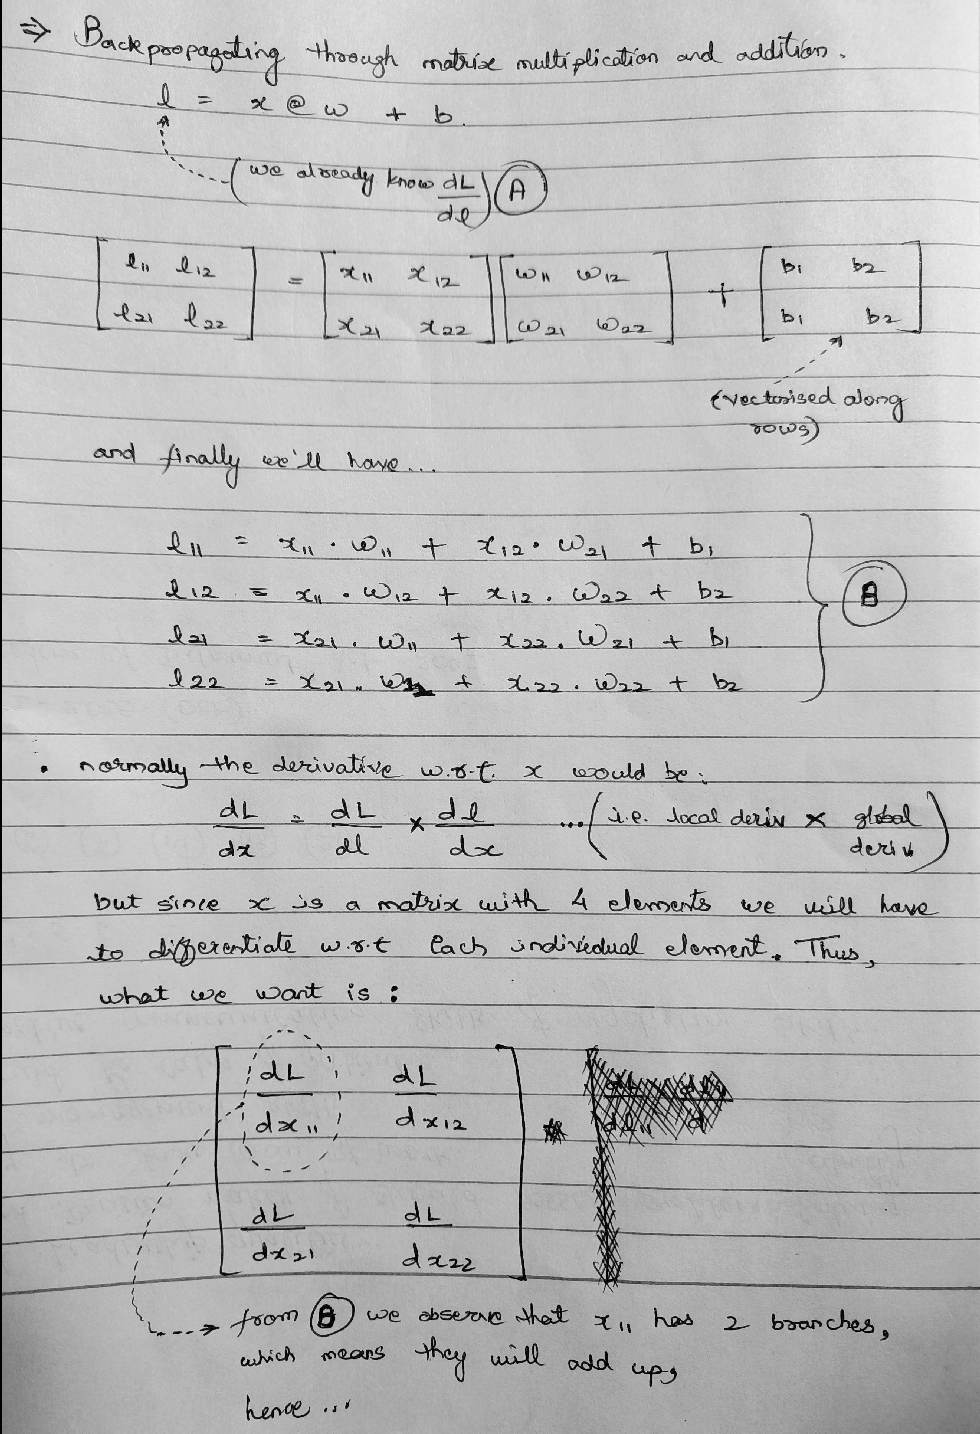

<br>

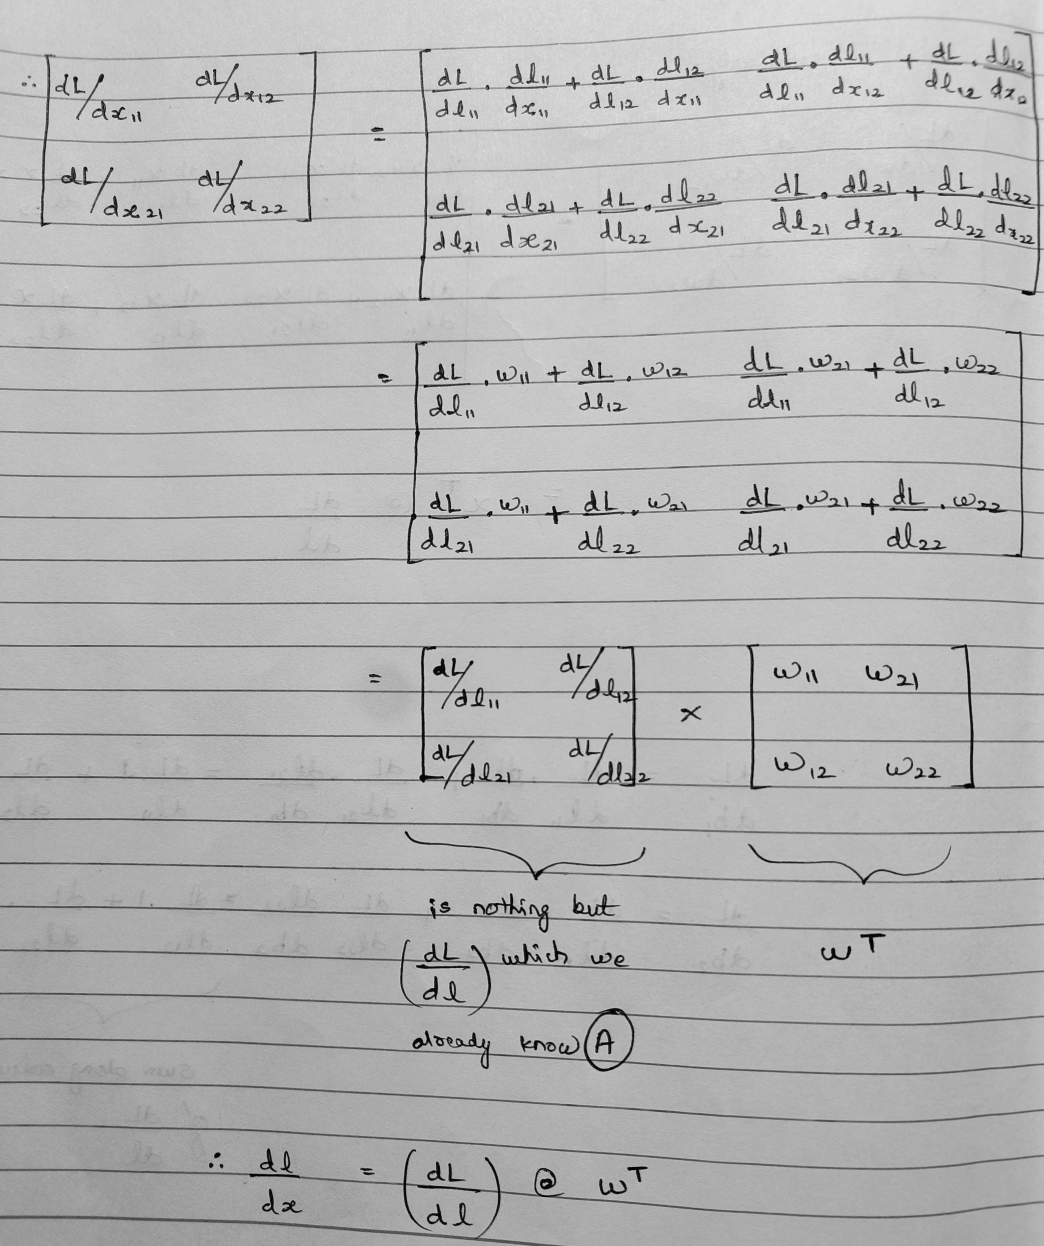

In [13]:
##10. logits = X_train_batch_embeds @ weights + bias 
X_train_batch_embeds_global_grad = logits_global_grad @ weights.T
compareTheDerivatives("X_train_batch_embeds")

(True, '0.0000001192092896')

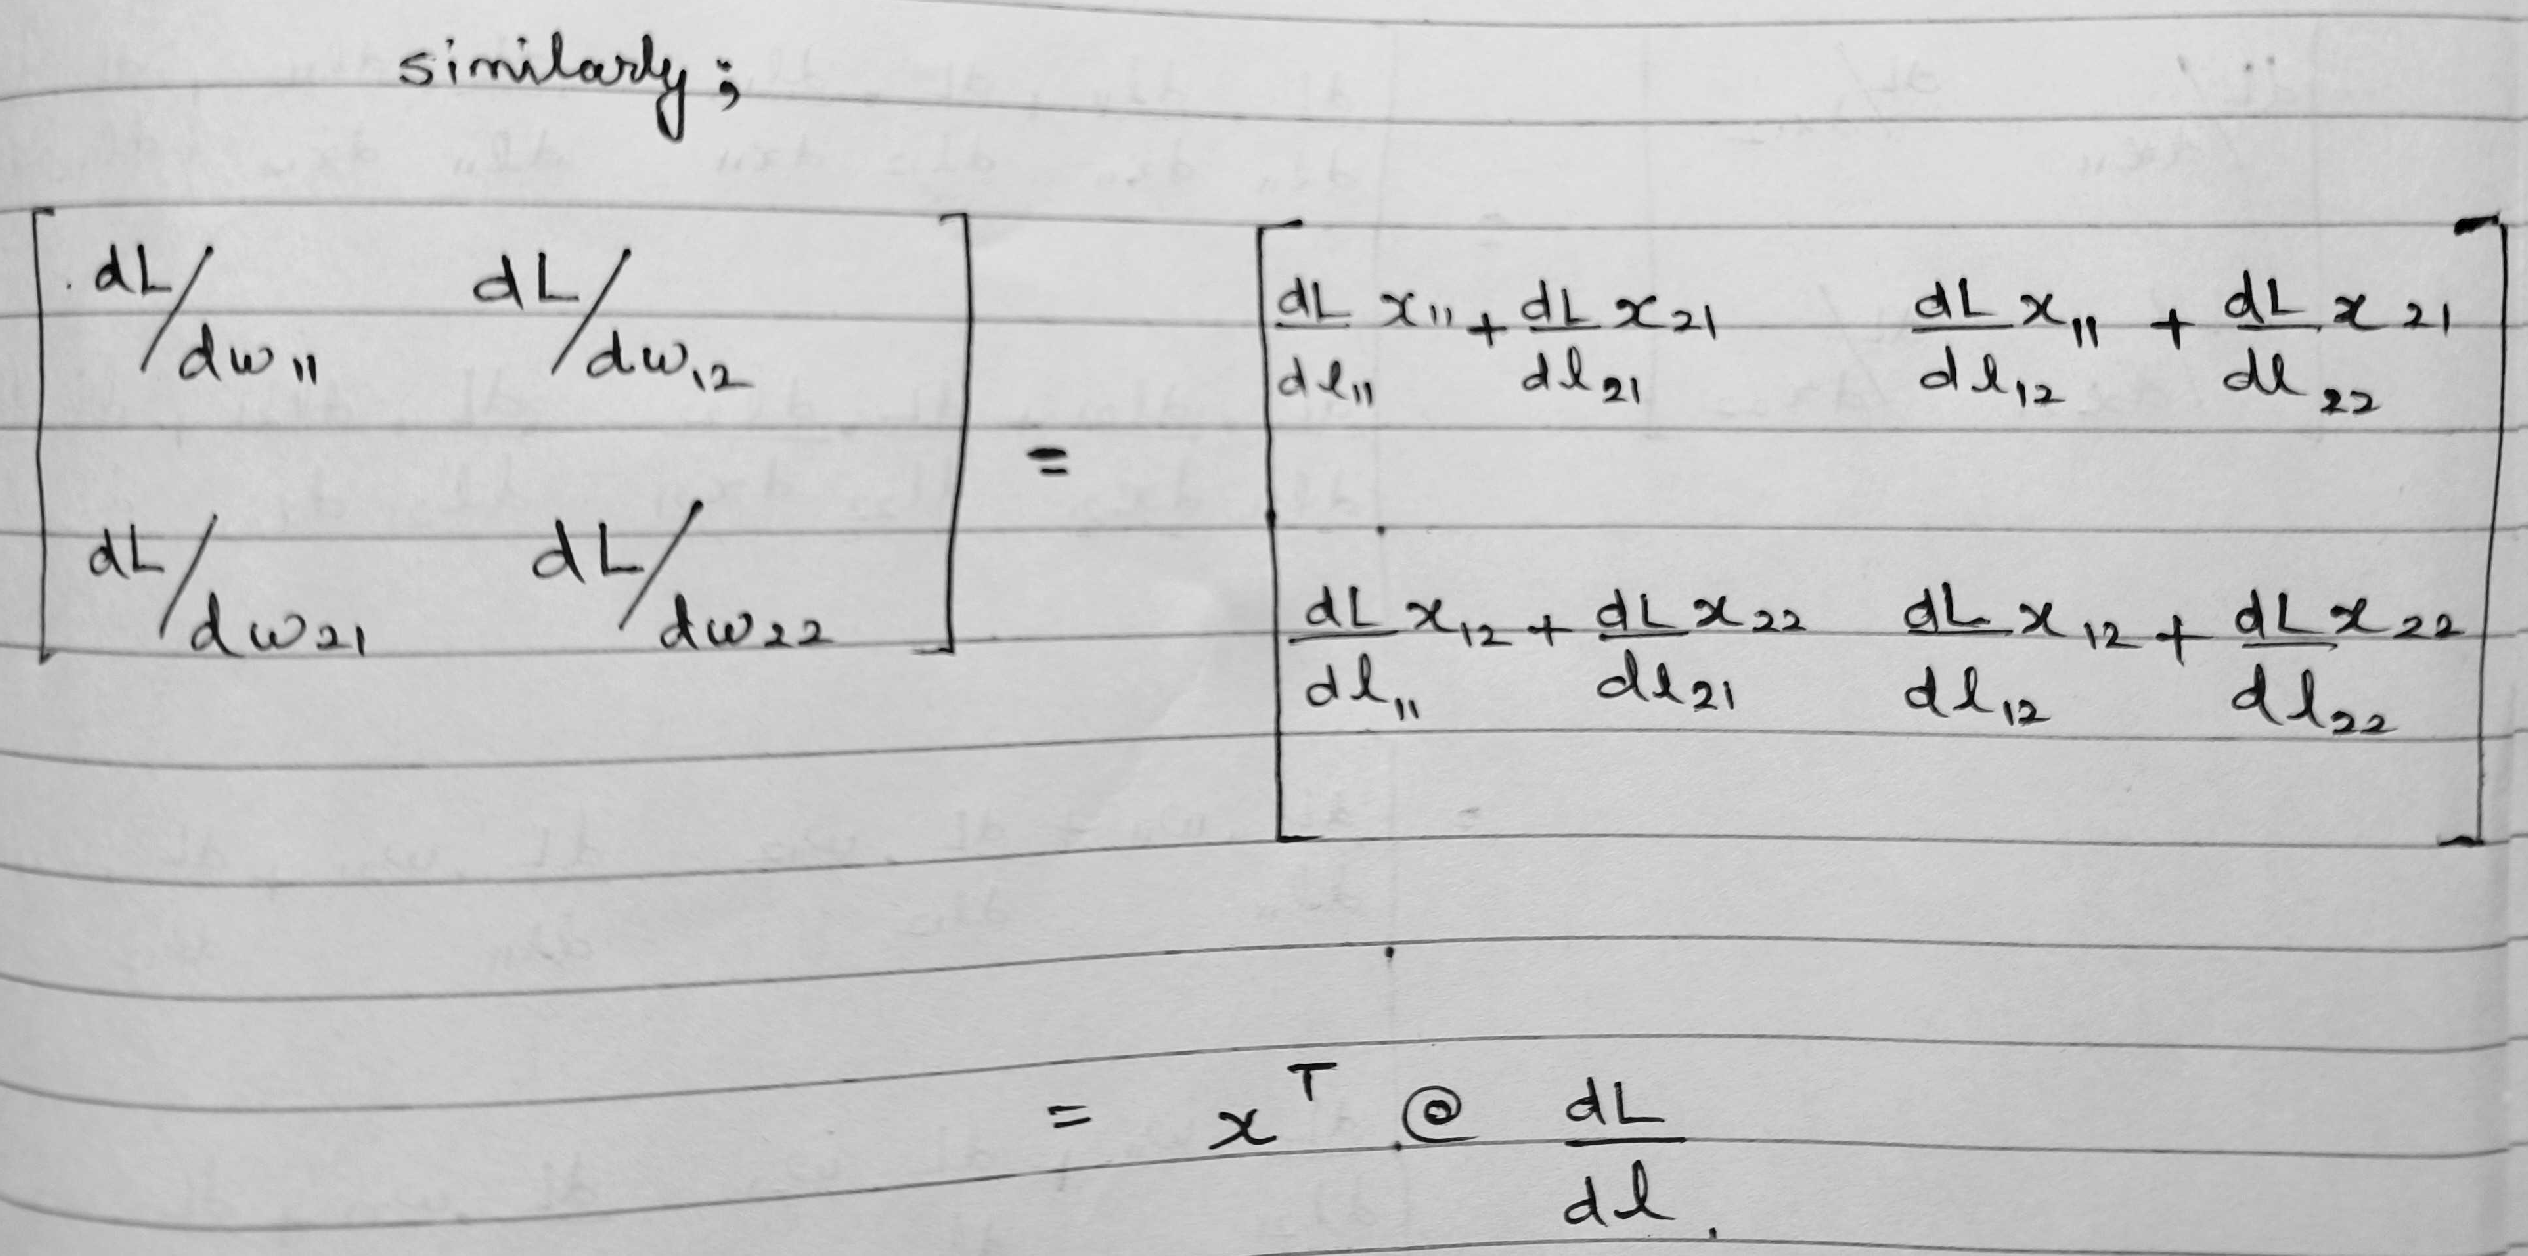

In [14]:
##10. logits = X_train_batch @ weights + bias
weights_global_grad = X_train_batch_embeds.T @ logits_global_grad
compareTheDerivatives("weights")

(True, '0.0000000596046448')

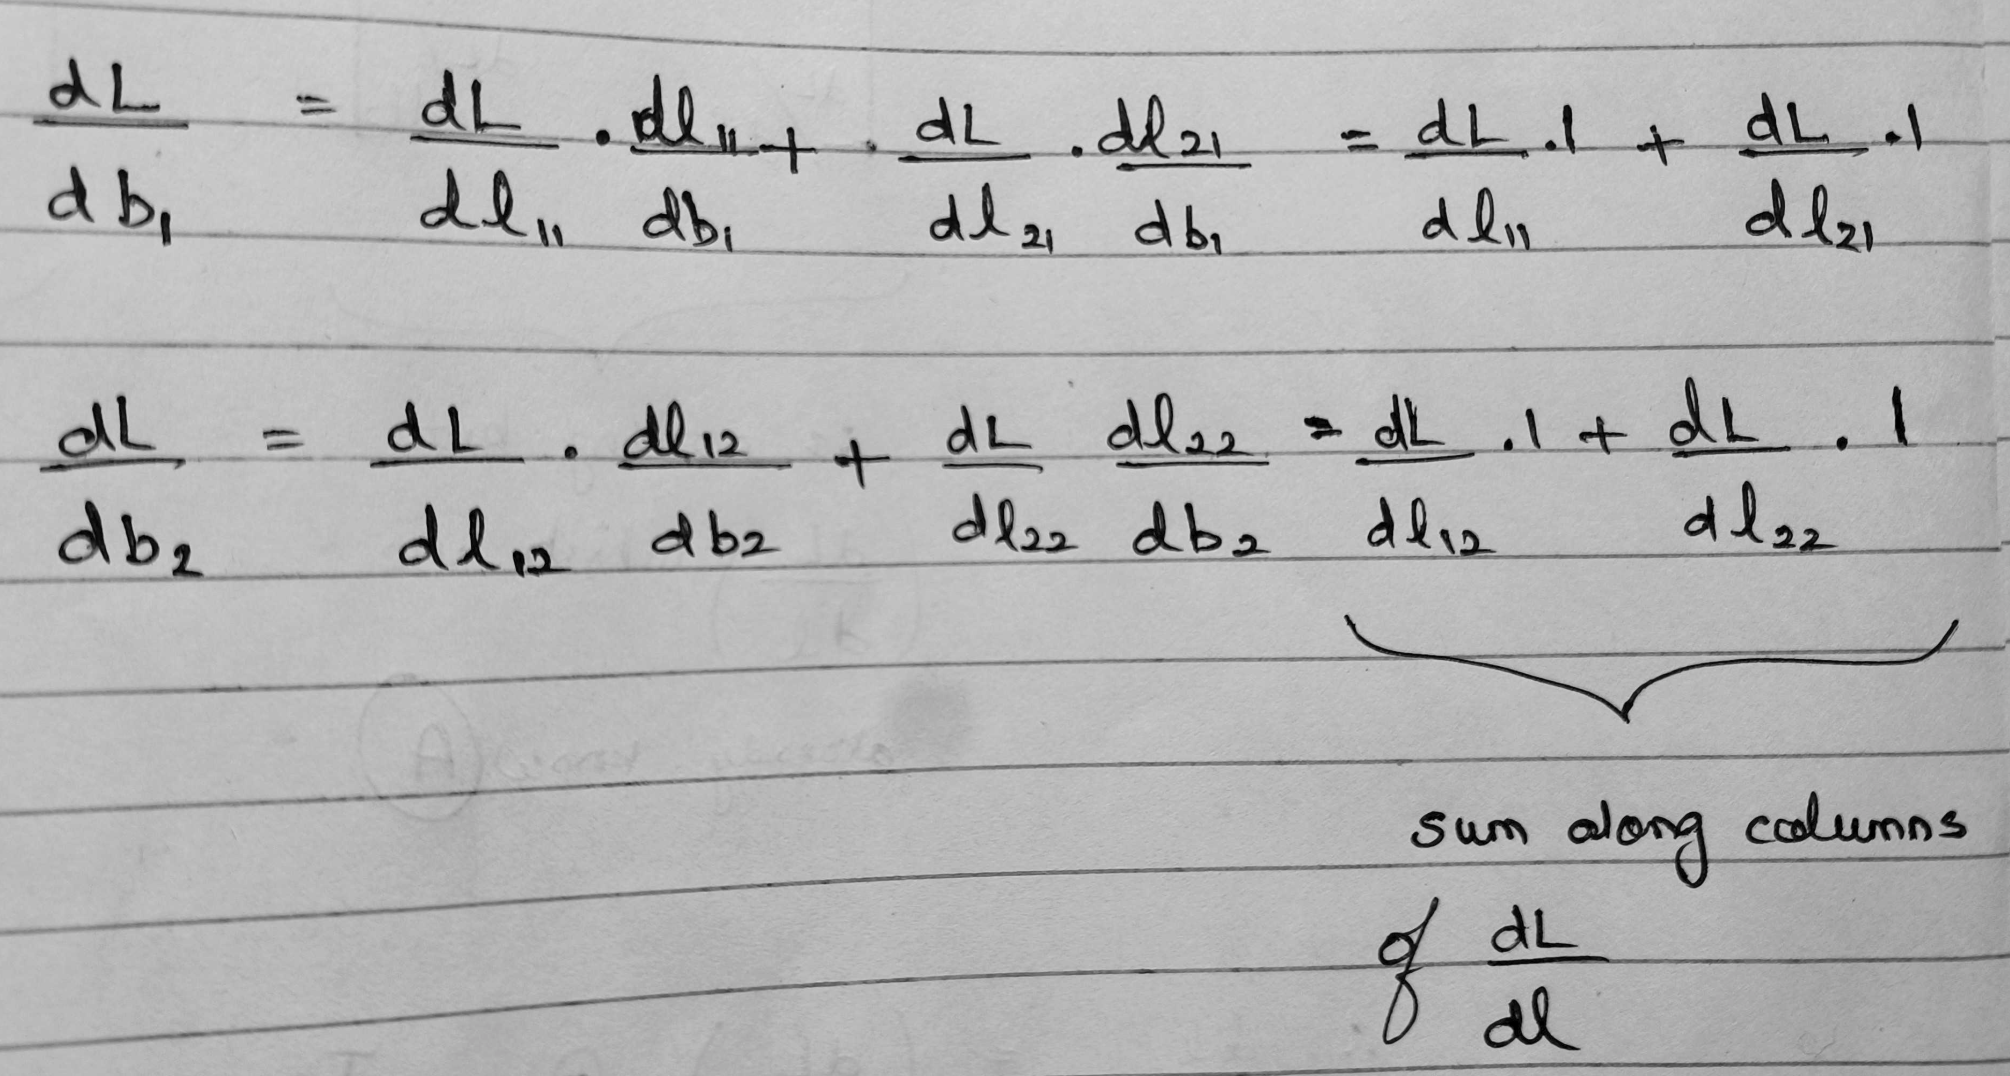

In [15]:
##10. logits = X_train_batch @ weights + bias
bias_global_grad = logits_global_grad.sum(ALONG_COLUMNS)
compareTheDerivatives("bias")

(True, '0.0000000298023224')